In [1]:
import os
import sys

import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Load

In [2]:
from scipy.io import loadmat

base_dir = "/home/hadi/Documents/CaDynamics"

anesthetized = loadmat(pjoin(base_dir, "anaesthesia_data.mat"))['data_all']
awake = loadmat(pjoin(base_dir, "awake_data.mat"))['data_all']

anesthetized = {anesthetized[i, 1].item(): anesthetized[i, 0] for i in range(3)}
awake = {awake[i, 1].item(): awake[i, 0] for i in range(3)}

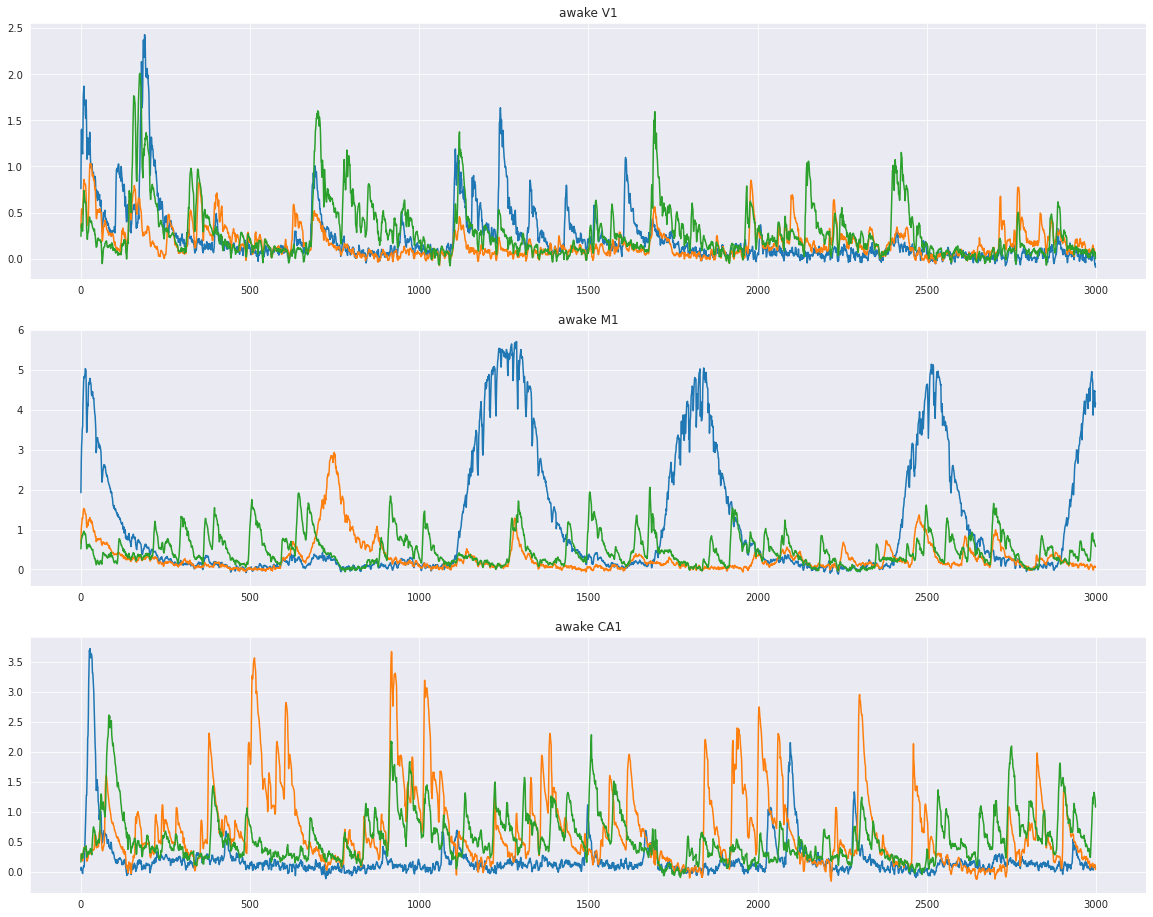

In [3]:
sns.set_style('darkgrid')

plt.figure(figsize=(20, 16))

plt.subplot(311)
plt.plot(awake['V1'][:, :3])
plt.title("awake V1")

plt.subplot(312)
plt.plot(awake['M1'][:, :3])
plt.title("awake M1")

plt.subplot(313)
plt.plot(awake['CA1'][:, :3])
plt.title("awake CA1")

plt.show()

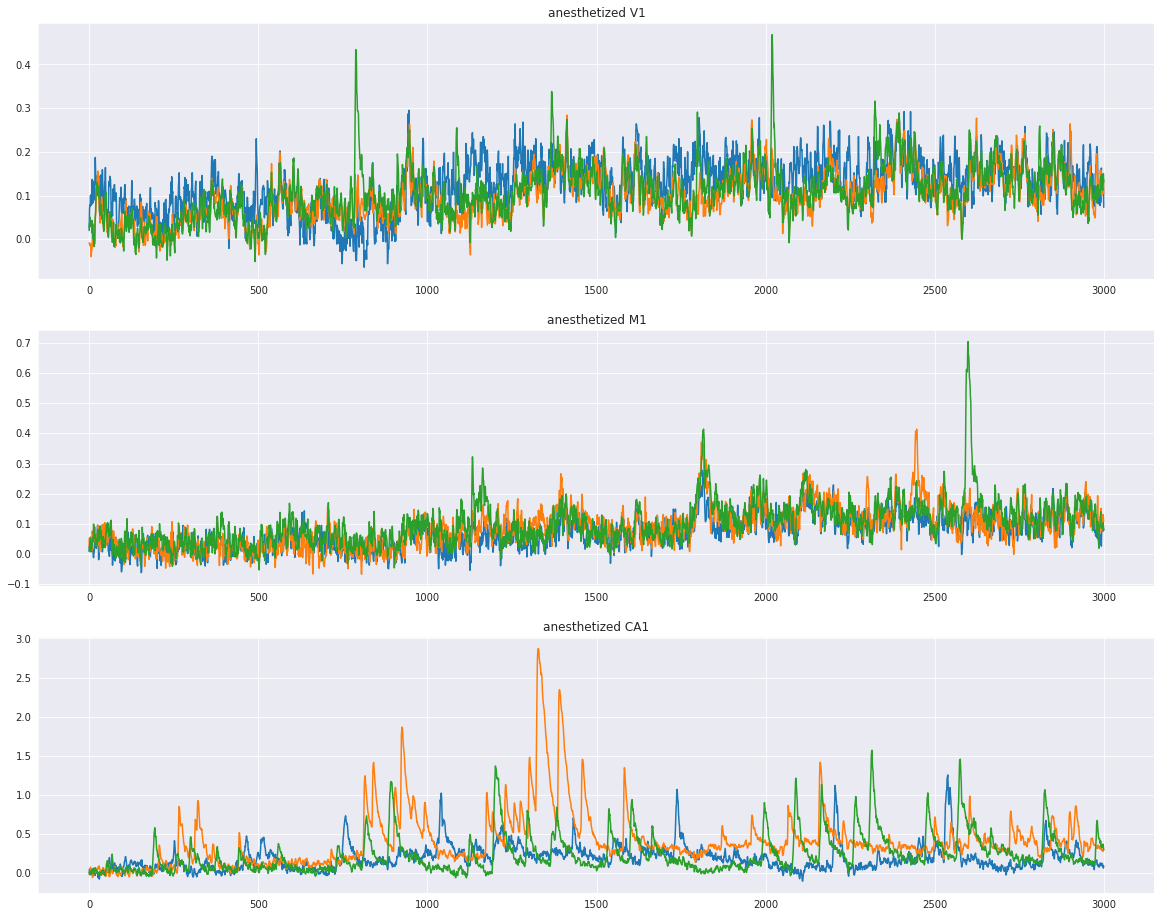

In [4]:
plt.figure(figsize=(20, 16))

plt.subplot(311)
plt.plot(anesthetized['V1'][:, :3])
plt.title("anesthetized V1")

plt.subplot(312)
plt.plot(anesthetized['M1'][:, :3])
plt.title("anesthetized M1")

plt.subplot(313)
plt.plot(anesthetized['CA1'][:, :3])
plt.title("anesthetized CA1")

plt.show()

### Firing rates

The mean of trajectories will give us a sense of firing rates

In [5]:
np.mean(awake['V1']), np.mean(awake['M1']), np.mean(awake['CA1'])

(0.16736089671361506, 0.44334335135135144, 0.2901355410628019)

In [6]:
np.mean(anesthetized['V1']), np.mean(anesthetized['M1']), np.mean(anesthetized['CA1'])

(0.12646263849765257, 0.15589362162162163, 0.2901496908212561)

# Process data

In [7]:
nb_v1_cells = awake['V1'].shape[-1]
nb_m1_cells = awake['M1'].shape[-1]
nb_ca1_cells = awake['CA1'].shape[-1]

nb_cells = nb_v1_cells + nb_m1_cells + nb_ca1_cells

# data
data_anesthetized = np.concatenate([anesthetized['V1'],
                                    anesthetized['M1'],
                                    anesthetized['CA1']], axis=-1)
data_awake = np.concatenate([awake['V1'],
                             awake['M1'],
                             awake['CA1']], axis=-1)
data_all = np.concatenate([data_anesthetized, data_awake], axis=0)

# labels
condition = ["anesthetized"] * nb_cells + ["awake"] * nb_cells
region = ["V1"] * nb_v1_cells + ["M1"] * nb_m1_cells + ["CA1"] * nb_ca1_cells
region = list(np.tile(region, 2))

data_anesthetized.shape, data_awake.shape, data_all.shape

((3000, 214), (3000, 214), (6000, 214))

# PCA

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_time = pca.fit_transform(data_awake)
pc_cells = pca.fit_transform(data_awake.T)

pc_time.shape, pc_cells.shape

((3000, 2), (214, 2))

In [14]:
data_dict = {
    "x": pc_cells[:, 0],
    "y": pc_cells[:, 1],
    "condition": condition[nb_cells:],
    "region": region[nb_cells:],
}
df = pd.DataFrame(data_dict)
df.head()

,x,y,condition,region
0,-4.478134,-0.121208,awake,V1
1,-7.925369,-0.174101,awake,V1
2,-0.708494,4.536384,awake,V1
3,-10.826624,0.115081,awake,V1
4,-8.059944,-0.600827,awake,V1


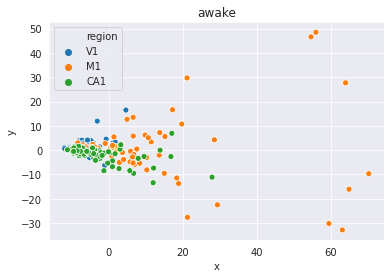

In [15]:
sns.scatterplot(x="x", y="y", hue="region", data=df)
plt.title("awake");

We see that PCA in this case doesn't reveal any strcutre

# Trajectory in PC space

In [17]:
pc_time = pca.fit_transform(data_all)
pc_time_anesthetized = pc_time[:3000]
pc_time_awake = pc_time[3000:]

pc_time_anesthetized.shape, pc_time_awake.shape

((3000, 2), (3000, 2))

In [18]:
pca.explained_variance_

array([5.82253603, 2.26488913])

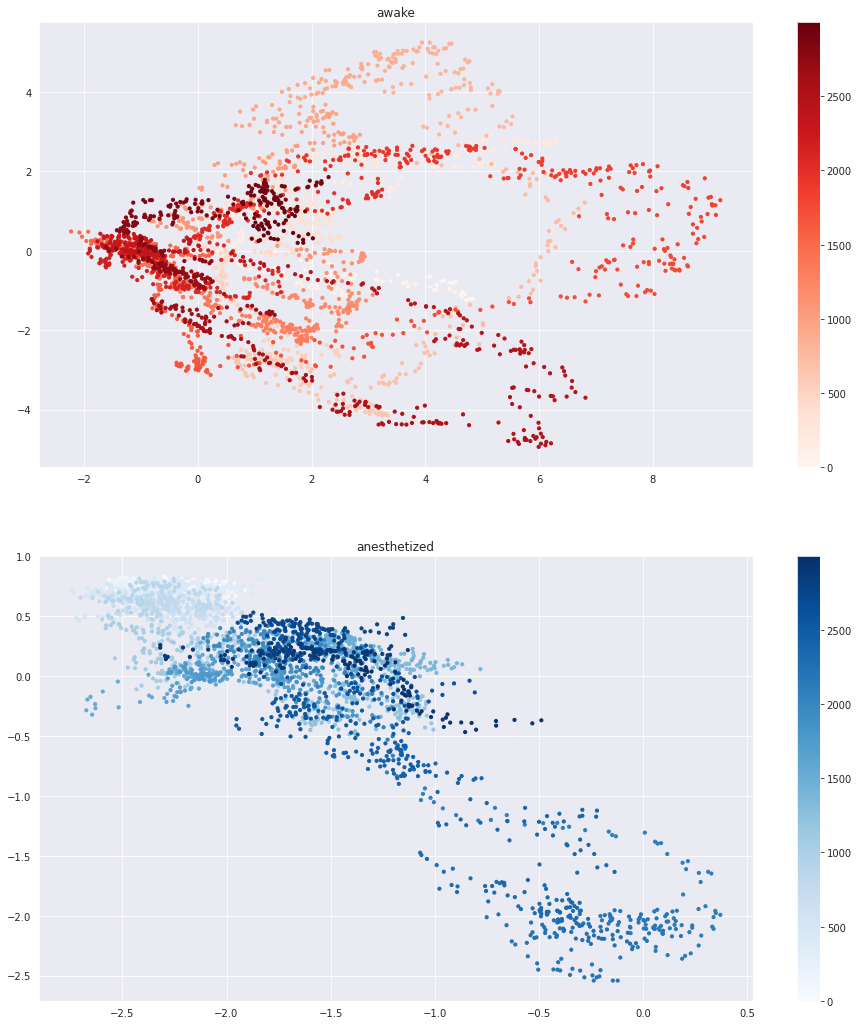

In [19]:
plt.figure(figsize=(16, 18))

plt.subplot(211)
plt.scatter(pc_time_awake[:, 0], pc_time_awake[:, 1], c=np.arange(3000), cmap="Reds", s=10)
plt.title("awake")
plt.colorbar()

plt.subplot(212)
plt.scatter(pc_time_anesthetized[:, 0], pc_time_anesthetized[:, 1], c=np.arange(3000), cmap="Blues", s=10)
plt.title("anesthetized")
plt.colorbar()

plt.show()

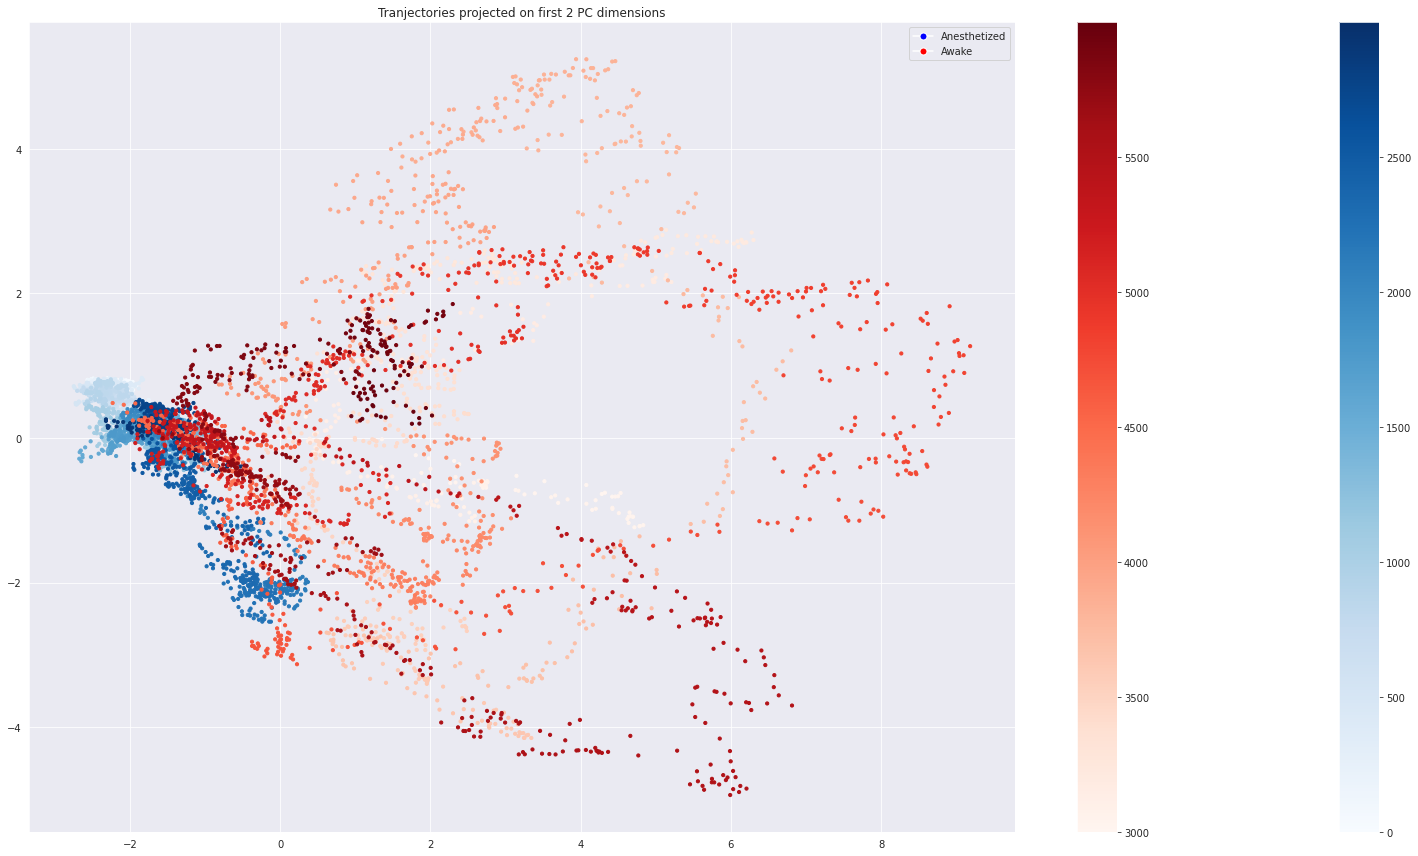

In [20]:
plt.figure(figsize=(22, 12))

plt.scatter(
    pc_time_anesthetized[:, 0], pc_time_anesthetized[:, 1],
    c=np.arange(3000), cmap="Blues", s=10, label="Awake")
plt.colorbar()

plt.scatter(
    pc_time_awake[:, 0], pc_time_awake[:, 1],
    c=np.arange(3000, 6000), cmap="Reds", s=10, label="Anesthetized")
plt.colorbar()

plt.title("Tranjectories projected on first 2 PC dimensions")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], marker='o', color='w', label='Scatter',
           markerfacecolor='b', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Scatter',
           markerfacecolor='r', markersize=7),
]
plt.legend(custom_lines, ['Anesthetized', 'Awake'])

plt.tight_layout()
plt.savefig("pca.pdf", facecolor="white", dpi=200)
plt.show()

# t-SNE

In [8]:
from sklearn.manifold import TSNE

x_emb_time = TSNE(n_components=2).fit_transform(data_all)
x_emb_anesthetized = TSNE(n_components=2, perplexity=5).fit_transform(data_anesthetized.T)
x_emb_awake = TSNE(n_components=2, perplexity=3).fit_transform(data_awake.T)

x_emb_time.shape, x_emb_anesthetized.shape, x_emb_awake.shape

((6000, 2), (214, 2), (214, 2))

In [9]:
data_dict = {
    "x": x_emb_anesthetized[:, 0],
    "y": x_emb_anesthetized[:, 1],
    "region": region[:nb_cells],}
df_anesthetized = pd.DataFrame(data_dict)

data_dict = {
    "x": x_emb_awake[:, 0],
    "y": x_emb_awake[:, 1],
    "region": region[nb_cells:],}
df_awake = pd.DataFrame(data_dict)

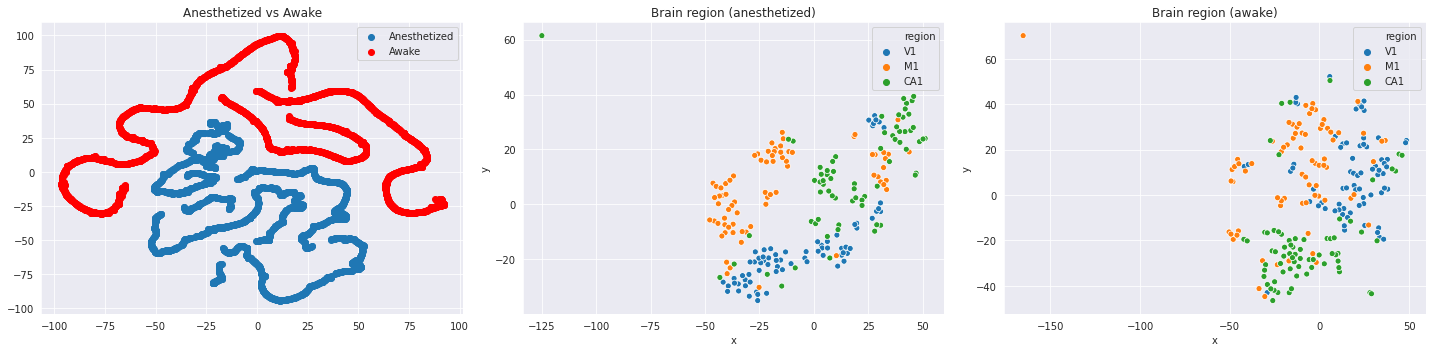

In [10]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.scatter(x_emb_time[:3000, 0], x_emb_time[:3000, 1], label="Anesthetized")
plt.scatter(x_emb_time[3000:, 0], x_emb_time[3000:, 1], color="r", label="Awake")
plt.title('Anesthetized vs Awake')
plt.legend()

plt.subplot(132)
sns.scatterplot(x="x", y="y", hue="region", data=df_anesthetized)
plt.title('Brain region (anesthetized)')

plt.subplot(133)
sns.scatterplot(x="x", y="y", hue="region", data=df_awake)
plt.title('Brain region (awake)')

plt.tight_layout()
plt.savefig("tsne.pdf", facecolor="white", dpi=200)
plt.show()

# Autoencoder

- PCA = one layer linear autoencoder
- next step: add another layer and a nonlinearity
- not that meaningful: completely ignores temporal dynamics

In [74]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

home_dir = os.environ['HOME']
sys.path.insert(0, pjoin(home_dir, 'Dropbox/git/CaDynamics'))
from generic_utils import *
from model_utils import print_num_params
from model import AutoEncoder

In [88]:
nt, nc = data_awake.shape
nt, nc

(3000, 214)

- autoencoder with z dim = 4

In [109]:
ae = AutoEncoder([128, 4], nc, wd=3, lr=1e-4, tmax=10, verbose=True).cuda()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
| AutoEncoder |   56282    |
|     ---     |    ---     |
|   encoder   |   28036    |
|   decoder   |   28246    |
|  criterion  |     0      |
+-------------+------------+ 




In [110]:
ae.encoder

Sequential(
  (0): Linear(in_features=214, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=4, bias=True)
)

In [111]:
ae.decoder

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=214, bias=True)
)

In [112]:
from sklearn.metrics import r2_score

### Train

In [113]:
trn_ids, tst_ids = np.arange(0, 9 * nt // 10), np.arange(9 * nt // 10, nt)
assert not set(trn_ids).intersection(set(tst_ids)), "train/test indices must be disjoint"

data_awake_trn = data_awake[trn_ids]
data_awake_tst = data_awake[tst_ids]

len(data_awake_trn), len(data_awake_tst)

(2700, 300)

epoch # 9. avg loss: 35.9249: 100%|██████████| 85/85 [00:00<00:00, 176.54it/s]


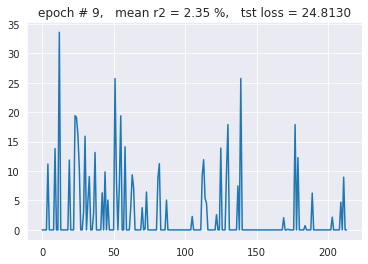

epoch # 19. avg loss: 35.1162: 100%|██████████| 85/85 [00:00<00:00, 173.75it/s]


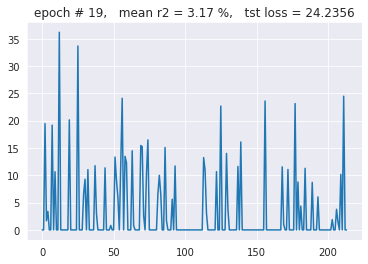

epoch # 29. avg loss: 30.7951: 100%|██████████| 85/85 [00:00<00:00, 181.37it/s]


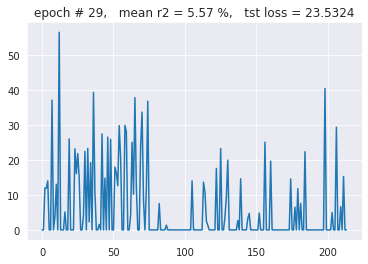

epoch # 39. avg loss: 30.9570: 100%|██████████| 85/85 [00:00<00:00, 177.91it/s]


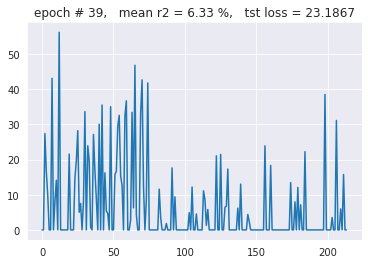

epoch # 49. avg loss: 28.3569: 100%|██████████| 85/85 [00:00<00:00, 174.23it/s]


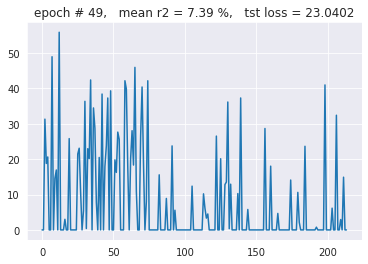

epoch # 59. avg loss: 28.8456: 100%|██████████| 85/85 [00:00<00:00, 176.21it/s]


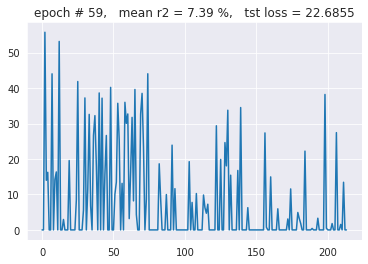

epoch # 69. avg loss: 26.7625: 100%|██████████| 85/85 [00:00<00:00, 175.56it/s]


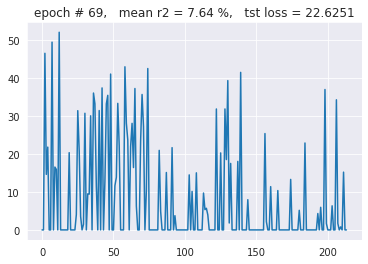

epoch # 79. avg loss: 27.5254: 100%|██████████| 85/85 [00:00<00:00, 179.02it/s]


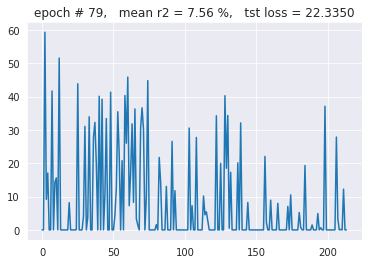

epoch # 89. avg loss: 25.9035: 100%|██████████| 85/85 [00:00<00:00, 180.55it/s]


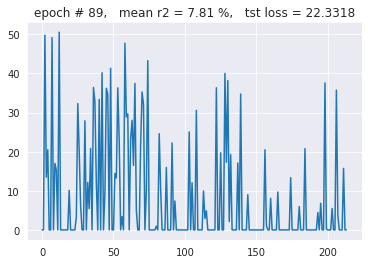

epoch # 99. avg loss: 26.8411: 100%|██████████| 85/85 [00:00<00:00, 172.46it/s]


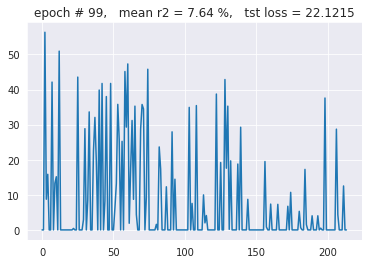

epoch # 109. avg loss: 25.4586: 100%|██████████| 85/85 [00:00<00:00, 182.52it/s]


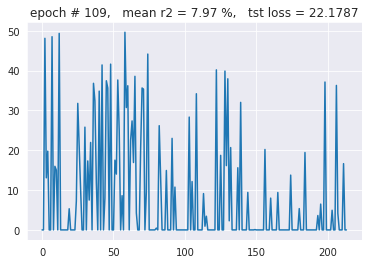

In [114]:
for epoch in range(110):
    ae.trn(data_awake_trn, batch_size=32, epoch=epoch)
    
    if (epoch + 1) % 10 == 0:
        _ = ae.tst(data_awake_tst, epoch)

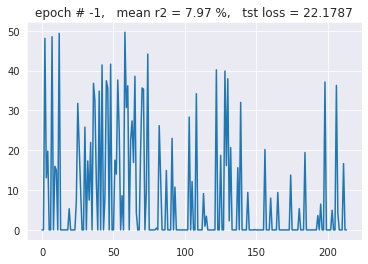

In [116]:
r2, x_np, y_np, z_np = ae.tst(data_awake_tst)

In [117]:
np.argsort(r2)[::-1][:20]

array([ 58,  12,   7,   2,  74,  48,  42, 122, 128,  65, 130,  53,  45,
       198,  36, 206,  60,  70,  46,  71])

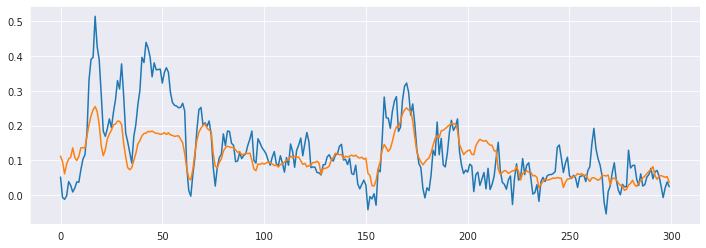

In [125]:
i = 58

plt.figure(figsize=(12, 4))
plt.plot(x_np[:, i])
plt.plot(y_np[:, i])

plt.show()

### compare performance to PCA
- n_components = 4

In [126]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pc_time = pca.fit_transform(data_awake_trn)

pc_time.shape

(2700, 4)

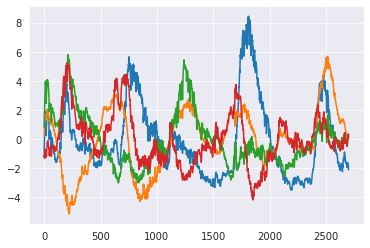

In [127]:
plt.plot(pc_time);

In [128]:
y_tst = pca.transform(data_awake_tst)
y_tst_pred = pca.inverse_transform(y_tst)

y_tst.shape, y_tst_pred.shape

((300, 4), (300, 214))

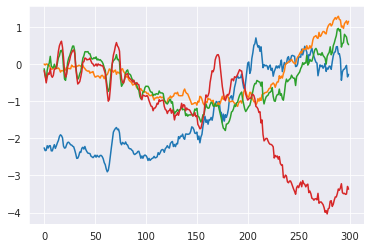

In [129]:
plt.plot(y_tst);

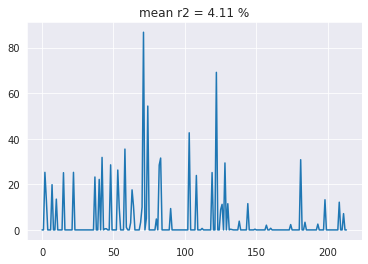

In [130]:
r2 = r2_score(data_awake_tst, y_tst_pred, multioutput='raw_values') * 100
r2_plus = np.maximum(r2, 0)

plt.plot(r2_plus)
msg = "mean r2 = {:.2f} {:s}"
msg = msg.format(r2_plus.mean(), "%")
plt.title(msg)
plt.show()

In [131]:
np.argsort(r2_plus)[::-1][:10]

array([ 71, 122,  74, 103,  58,  42,  83, 181, 128,  48])

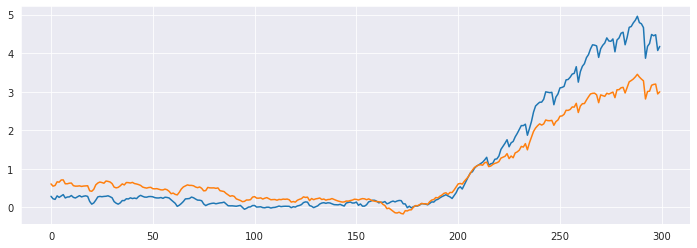

In [133]:
i = 71

plt.figure(figsize=(12, 4))
plt.plot(data_awake_tst[:, i])
plt.plot(y_tst_pred[:, i])